# 🔍 DEBUG: Почему scorecard пропускает фродеров?

Проблема: из 114 фродеров поймали только 4!

In [1]:
import pandas as pd
import numpy as np

# Загружаем ВСЕ результаты (включая авто-одобренные)
all_results = pd.read_csv("../docs/two_stage_detection_results.csv")

print(f"Total transactions: {len(all_results)}")
print(f"\nColumns: {all_results.columns.tolist()}")
all_results.head()

Total transactions: 13140

Columns: ['cst_dim_id', 'transdate', 'transdatetime', 'amount', 'docno', 'direction', 'target', 'os_count_30d', 'Количество разных моделей телефона (phone_model) за последние 30 дней — насколько часто клиент “менял устройство” по логам', 'last_phone_model', 'last_os_ver', 'logins_7d', 'Количество уникальных логин-сессий за последние 30 дней до transdate', 'avg_logins_7d', 'avg_logins_30d', 'rel_freq_change_7_30d', 'login_share_7_30d', 'avg_login_interval', 'std_login_interval', 'interval_variance_30d', 'weighted_avg_interval_7d', 'Показатель “взрывности” логинов: (std?mean)/(std+mean)(std - mean)/(std + mean)(std?mean)/(std+mean) для интервалов', 'fano_factor_interval', 'z_score_avg_interval_7d_vs_30d', 'hour', 'day_of_week', 'is_night', 'amount_log', 'is_high_risk_combo', 'is_fast_bot', 'time_since_last_login', 'user_avg_amt', 'user_std_amt', 'user_tx_count', 'user_hist_fraud', 'amount_to_avg_ratio', 'rare_os_flag', 'rare_device_flag', 'high_device_volatilit

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,os_count_30d,Количество разных моделей телефона (phone_model) за последние 30 дней — насколько часто клиент “менял устройство” по логам,last_phone_model,...,suspicious_device_combo,high_login_volatility,scorecard_total,fraud_probability,fraud_prediction,risk_level,detection_stage,device_count_30d,login_volatility_factor,is_device_hopper
0,2937833270,2025-01-05,2025-01-05 16:32:02,31000.0,5343,8406e407421ec28bd5f445793ef64fd1,0,1.0,1,"iPhone16,1",...,0,0,0,0.0,0,LOW,scorecard,NaN,NaN,NaN
1,2096229005,2025-03-04,2025-03-04 17:41:57,4000.0,8442,b3a3d4a6006293195d998957d4f01e42,0,1.0,1,Samsung SM-S918B,...,0,0,2,0.0,0,LOW,scorecard,NaN,NaN,NaN
2,2937759666,2025-06-20,2025-06-20 10:08:07,3000.0,9540,22b84292f0ebce65ad0808342615a03b,0,0.0,0,Unknown,...,0,0,0,0.0,0,LOW,scorecard,NaN,NaN,NaN
3,2933493153,2025-07-06,2025-07-06 14:52:13,500.0,11685,d677d4e1a0f625e1ad746ea950c9dca9,0,0.0,0,Vivo_v2339,...,0,0,2,0.0,0,LOW,scorecard,NaN,NaN,NaN
4,456000634,2024-12-18,2024-12-18 14:12:25,20000.0,7128,87b698d1edae13c21ce86678de3b8546,0,1.0,1,Samsung SM-A536E,...,0,0,2,0.0,0,LOW,scorecard,NaN,NaN,NaN


## 1. Проверка: сколько РЕАЛЬНЫХ фродеров было авто-одобрено?

In [2]:
if 'target' in all_results.columns:
    # Всего фродеров
    total_frauds = all_results['target'].sum()
    print(f"🎯 Total REAL frauds: {total_frauds}")
    
    # Фродеры которые прошли в ML check
    ml_checked_frauds = all_results[all_results['detection_stage'] == 'ml_model']['target'].sum()
    print(f"🤖 Frauds sent to ML: {ml_checked_frauds}")
    
    # Фродеры которые были авто-одобрены (ПРОПУЩЕНЫ!)
    auto_approved_frauds = all_results[all_results['detection_stage'] == 'scorecard']['target'].sum()
    print(f"\n❌ MISSED by scorecard (auto-approved): {auto_approved_frauds}")
    print(f"   Это {auto_approved_frauds/total_frauds*100:.1f}% всех фродов!")
    
    # Scorecard Recall
    scorecard_recall = ml_checked_frauds / total_frauds * 100
    print(f"\n📊 Scorecard Recall: {scorecard_recall:.1f}%")
    print(f"   (сколько фродеров отправил на ML-проверку из всех)")
else:
    print("⚠️ No target column!")

🎯 Total REAL frauds: 165
🤖 Frauds sent to ML: 8

❌ MISSED by scorecard (auto-approved): 157
   Это 95.2% всех фродов!

📊 Scorecard Recall: 4.8%
   (сколько фродеров отправил на ML-проверку из всех)


## 2. Анализ ПРОПУЩЕННЫХ фродеров (авто-одобренных)

In [3]:
if 'target' in all_results.columns and 'scorecard_total' in all_results.columns:
    # Фродеры которых scorecard пропустил
    missed_frauds = all_results[
        (all_results['target'] == 1) & 
        (all_results['detection_stage'] == 'scorecard')
    ]
    
    print(f"\n🔍 Analyzing {len(missed_frauds)} MISSED frauds...\n")
    
    # Распределение их scorecard scores
    print("📊 Scorecard scores of MISSED frauds:")
    print(missed_frauds['scorecard_total'].value_counts().sort_index())
    print(f"\nMean scorecard: {missed_frauds['scorecard_total'].mean():.2f}")
    print(f"Max scorecard: {missed_frauds['scorecard_total'].max():.0f}")
    
    # Scorecard фичи у пропущенных
    scorecard_cols = ['rare_os_flag', 'rare_device_flag', 'suspicious_device_combo', 
                      'high_device_volatility', 'high_login_volatility']
    available_cols = [c for c in scorecard_cols if c in missed_frauds.columns]
    
    if available_cols:
        print(f"\n📋 Scorecard features of MISSED frauds (mean):")
        print(missed_frauds[available_cols].mean())
        
        # Примеры
        print(f"\n❌ Examples of MISSED frauds:")
        display_cols = ['scorecard_total'] + available_cols
        print(missed_frauds[display_cols].head(10))


🔍 Analyzing 157 MISSED frauds...

📊 Scorecard scores of MISSED frauds:
scorecard_total
0    61
2    96
Name: count, dtype: int64

Mean scorecard: 1.22
Max scorecard: 2

📋 Scorecard features of MISSED frauds (mean):
rare_os_flag               0.108280
rare_device_flag           0.503185
suspicious_device_combo    0.000000
high_device_volatility     0.000000
high_login_volatility      0.000000
dtype: float64

❌ Examples of MISSED frauds:
     scorecard_total  rare_os_flag  rare_device_flag  suspicious_device_combo  \
87                 2             0                 1                        0   
154                2             0                 1                        0   
202                2             0                 1                        0   
255                0             0                 0                        0   
277                2             1                 0                        0   
281                0             0                 0                     

## 3. Сравнение: ПРОПУЩЕННЫЕ vs ПОЙМАННЫЕ фродеры


📊 COMPARISON: Missed vs Caught frauds

                         Missed_by_Scorecard  Caught_by_Scorecard  Difference
scorecard_total                     1.222930                  4.0    2.777070
rare_os_flag                        0.108280                  1.0    0.891720
rare_device_flag                    0.503185                  1.0    0.496815
suspicious_device_combo             0.000000                  0.0    0.000000
high_device_volatility              0.000000                  0.0    0.000000
high_login_volatility               0.000000                  0.0    0.000000


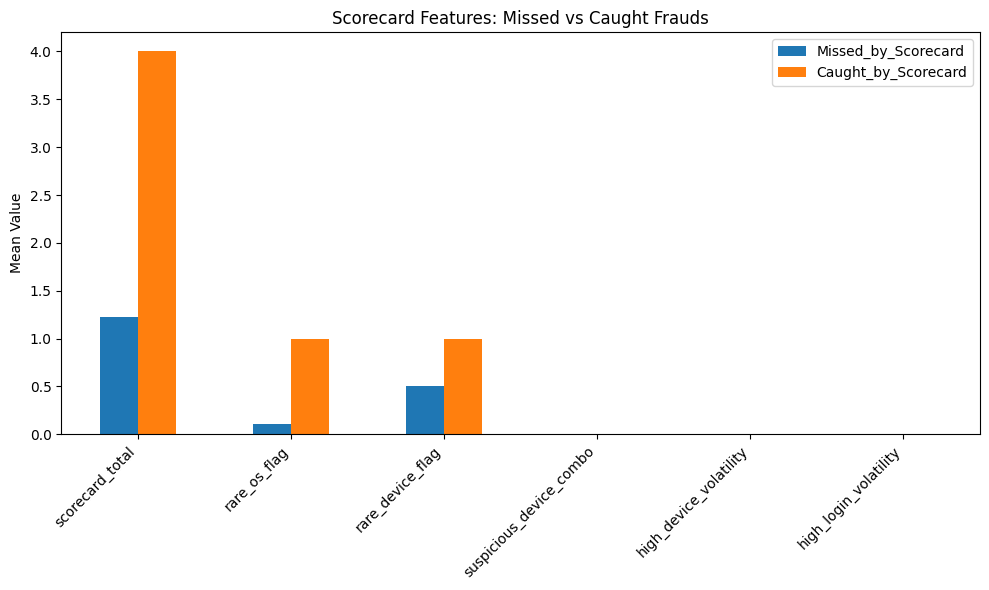

In [4]:
if 'target' in all_results.columns and 'scorecard_total' in all_results.columns:
    # Фродеры отправленные на ML-проверку
    caught_frauds = all_results[
        (all_results['target'] == 1) & 
        (all_results['detection_stage'] == 'ml_model')
    ]
    
    print("\n📊 COMPARISON: Missed vs Caught frauds\n")
    
    comparison = pd.DataFrame({
        'Missed_by_Scorecard': missed_frauds[['scorecard_total'] + available_cols].mean(),
        'Caught_by_Scorecard': caught_frauds[['scorecard_total'] + available_cols].mean()
    })
    comparison['Difference'] = comparison['Caught_by_Scorecard'] - comparison['Missed_by_Scorecard']
    
    print(comparison)
    
    # Визуализация
    import matplotlib.pyplot as plt
    comparison[['Missed_by_Scorecard', 'Caught_by_Scorecard']].plot(kind='bar', figsize=(10, 6))
    plt.title('Scorecard Features: Missed vs Caught Frauds')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 4. ВЫВОД: Нужно ПОНИЗИТЬ порог scorecard!

In [5]:
print("\n" + "="*60)
print("🎯 RECOMMENDATIONS")
print("="*60)

if 'scorecard_total' in all_results.columns and 'target' in all_results.columns:
    # Тестируем разные пороги
    print("\n📊 Testing different scorecard thresholds:\n")
    
    for threshold in [0, 1, 2, 3]:
        # Сколько отправится на ML
        needs_ml = all_results[all_results['scorecard_total'] > threshold]
        ml_rate = len(needs_ml) / len(all_results) * 100
        
        # Сколько фродеров поймаем
        frauds_caught = needs_ml['target'].sum()
        recall = frauds_caught / total_frauds * 100
        
        print(f"Threshold > {threshold}:")
        print(f"  ML check rate: {ml_rate:.1f}% ({len(needs_ml)} transactions)")
        print(f"  Frauds caught: {frauds_caught}/{total_frauds} (Recall: {recall:.1f}%)")
        print()
    
    print("\n💡 RECOMMENDATION:")
    print("  Use threshold = 0 or 1 to catch more frauds!")
    print("  Current threshold = 2 is TOO HIGH!")
    print("="*60)


🎯 RECOMMENDATIONS

📊 Testing different scorecard thresholds:

Threshold > 0:
  ML check rate: 55.4% (7278 transactions)
  Frauds caught: 104/165 (Recall: 63.0%)

Threshold > 1:
  ML check rate: 55.4% (7278 transactions)
  Frauds caught: 104/165 (Recall: 63.0%)

Threshold > 2:
  ML check rate: 1.8% (233 transactions)
  Frauds caught: 8/165 (Recall: 4.8%)

Threshold > 3:
  ML check rate: 1.8% (233 transactions)
  Frauds caught: 8/165 (Recall: 4.8%)


💡 RECOMMENDATION:
  Use threshold = 0 or 1 to catch more frauds!
  Current threshold = 2 is TOO HIGH!
